# Feral Pigs in CA
- Search the latest GBIF snapshot in the Planetary Computer for pig (*Sus scroga*) sightings in California, US. 
- Plot a map with the occurrences 
- Count how many records there are per year
- Check if any pigs were recorded in Sedgwick's reserve bounding box

More info on GBIF dataset:

https://github.com/microsoft/AIforEarthDataSets/blob/main/data/gbif.md

https://data-blog.gbif.org/post/gbif-filtering-guide/

NOTE: the libraries are imported as needed to make it explicit where they are used. The libraries used in the notebook are:

`pystac_client`
`planetary_computer`
`dask.dataframe`
`dask_gateway`

`geopandas`
`matplotlib.pyplot`


## Acessing data

In [1]:
import pystac_client # access STAC catalogs
import planetary_computer # sign items
import dask.dataframe as dd # dataframe optimized for parallel computing

# ----- accesing Azure storage using pystac client
URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = pystac_client.Client.open(URL)


# ----- access items in gbif catalog
search = catalog.search(collections=["gbif"])
items = search.get_all_items()
items = {x.id: x for x in items}
#list(items)


# ---- select and sign first item
# The snapshot includes all CC-BY licensed data published through GBIF that have coordinates which passed automated quality checks.
item = list(items.values())[0]
#print(item) 

signed_asset = planetary_computer.sign(item).assets["data"]



In [2]:
# ---- read data frame using parquet, specify columns to be included

df = dd.read_parquet(
    signed_asset.href,
    columns=["class",
            "species",
            "stateprovince",
            "eventdate",
            "year",
            "month",
            "day",
            "decimallatitude",
            "decimallongitude"],
    storage_options=signed_asset.extra_fields["table:storage_options"],  #???
)
#df


## Data preparation

In [3]:
# ---- initialize dask cluster ---
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(16)
client = cluster.get_client()
print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.78354a6e33654215ad5b8ecea2bf99b8/status


In [4]:
ca_obs = df.loc[df['stateprovince'] == 'California'].compute()

In [5]:
ca_pigs = ca_obs.loc[ca_obs['species'] == 'Sus scrofa']
#ca_pigs

In [6]:
# need to transform lat long entries into point geometry for plotting

import geopandas

geo_pigs = geopandas.GeoDataFrame(
    ca_pigs, 
    geometry = geopandas.points_from_xy(x=ca_pigs.decimallongitude, y=ca_pigs.decimallatitude)
)
#geo_pigs

## Map observations

CA shapefile source: https://data.ca.gov/dataset/ca-geographic-boundaries/resource/3db1e426-fb51-44f5-82d5-a54d7c6e188b

In [7]:
# ---- OPENING SHAPEFILE ----
# the shp (espg 3857) and the point data (epsg 4326) have different crs, so we have to match them

CA_path = "/home/jovyan/Sedgwick_Reserve/CA_geometry/CA_State_TIGER2016.shp"
CA_shp = geopandas.read_file(CA_path)
#CA_shp.plot(edgecolor='purple', color='yellow')
#CA_shp.crs  # ESPSG: 3857
CA_shp = CA_shp.to_crs(4326) # match it to point data crs
#CA_shp.crs

<AxesSubplot:>

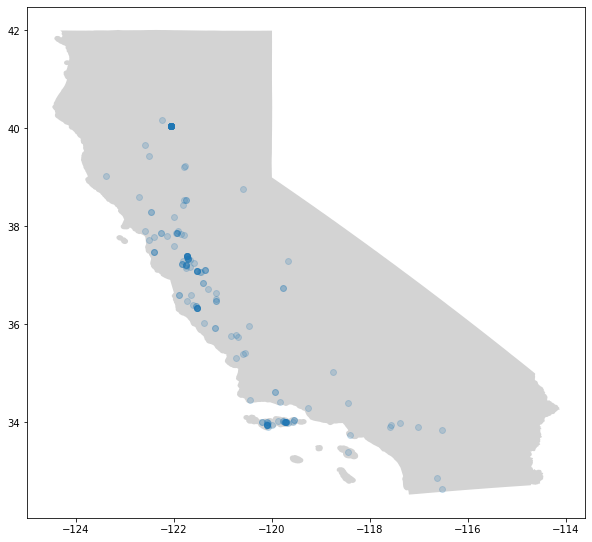

In [8]:
# ---- CREATE MAP ----

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10,10))
CA_shp.plot(ax=ax, color='lightgray')
geo_pigs.plot(ax=ax, alpha=0.2)



## Observations by year

In [25]:
# ---- COUNT OBSERVATIONS BY YEAR ----

# earliest is on 1818, latest on 2021

obs_by_year = ca_pigs.filter(items=['year']).groupby(['year']).size().reset_index(name='count')
print(obs_by_year.head(5))
print(obs_by_year.tail(5))

     year  count
0  1818.0     31
1  1910.0      1
2  1925.0      1
3  1927.0      4
4  1929.0      3
      year  count
42  2017.0      1
43  2018.0      9
44  2019.0     17
45  2020.0     20
46  2021.0     13


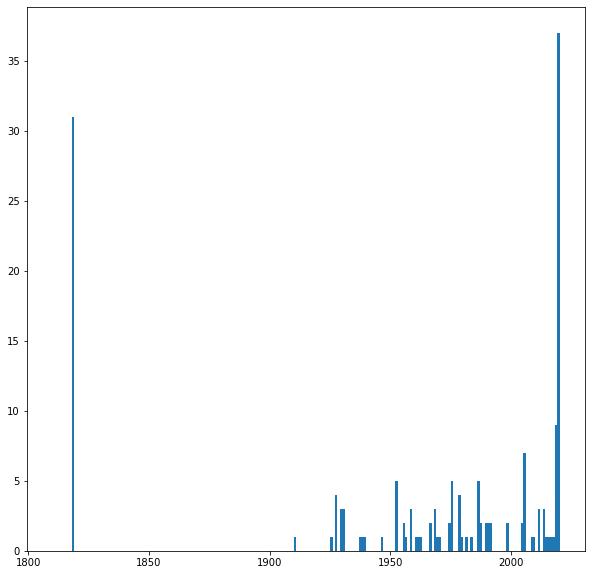

In [26]:
# ---- HISTOGRAM ----

fig, ax = plt.subplots(figsize =(10, 10))
ax.hist(ca_pigs.filter(items=['year']), bins = range(1810,2021))
plt.show()

## (no) Pigs at Sedgwick

Shapefile for Sedgiwck reserve come from UC Natural Reserve System Boundaries.

https://nrs-ucanr.opendata.arcgis.com/datasets/UCANR::uc-natural-reserve-system-boundaries/about

In [27]:
# ---- OPENING SHAPEFILE ----

sedg_shp_path = "/home/jovyan/Sedgwick_Reserve/sedgwick_geometry/sedgwick_geometry.shp"
sedg_shp = geopandas.read_file(sedg_shp_path)
#sedg_shp.plot(edgecolor='purple', color='yellow')

# --- matching CRS to data point
#print(sedg_shp.crs)
sedg_shp = sedg_shp.to_crs(4326)
#print(sedg_shp.crs)

In [28]:
# ----- FILTERING DATASET TO SEDGWICK BOUNDING BOX -----

#print(sedg_shp.bounds)

minx = sedg_shp.bounds['minx'][0]
miny = sedg_shp.bounds['miny'][0]
maxx = sedg_shp.bounds['maxx'][0]
maxy = sedg_shp.bounds['maxy'][0]

sedg_pigs = ca_pigs.loc[(miny < ca_pigs['decimallatitude'] ) & (ca_pigs['decimallatitude'] < maxy) &
          (minx < ca_pigs['decimallongitude'] ) & (ca_pigs['decimallongitude'] < maxx)]

sedg_pigs.size

0